# Airfoil Self-Noise Prediction

In [276]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

## Dataset

Το dataset που θα χρησιμοποιήσουμε υπάρχει στο UCI https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise. Η NASA κατέγραψε παρατηρήσεις πέντε διαφορετικών χαρακτηριστικών με σκοπό τη δημιουργία ενός μοντέλου που θα μπορεί να προβλέψει τον θόρυβο λεπίδων αεροτομών. Τα χαρακτηριστικά με τις μονάδες μέτρησής τους είναι τα εξής:
- Frequency, σε Hertzs
- Angle of attack, σε μοίρες
- Chord length, σε μέτρα
- Free-stream velocity, σε μέτρα ανά δευτερόλεπτο
- Suction side displacement thickness, σε μέτρα

και η μεταβλητή προς πρόβλεψη είναι η:
- Scaled sound pressure level, σε ντεσιμπέλ

Το dataset αποτελείται από 1503 δείγματα και όλα τα χαρακτηριστικά είναι αριθμητικά. Οι επικεφαλίδες των χαρακτηριστικών δεν παρέχονται, οπότε τις ορίζουμε εμείς κατά το διάβασμα του αρχείου, με την τελευταία στήλη να αποτελεί τη μεταβλητή στόχο.

In [218]:
# load data
data = pd.read_csv('data/airfoil_self_noise.dat', sep='\s+', header=None, 
                   names=['frequency', 'angle', 'length', 'velocity', 'thickness', 'sound'])

In [219]:
data.head()

,frequency,angle,length,velocity,thickness,sound
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [220]:
data.shape

(1503, 6)

In [221]:
data.dtypes

frequency      int64
angle        float64
length       float64
velocity     float64
thickness    float64
sound        float64
dtype: object

In [222]:
# Quick summary statistics of the dataset features
data.describe(include='all')

,frequency,angle,length,velocity,thickness,sound
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


Με τις παραπάνω εξόδους επιβεβαιώνουμε τον αριθμό δειγμάτων και χαρακτηριστικών, καθώς και τον τύπο τους. Στη συνέχεια, ελέγχουμε αν υπάρχουν απουσιάζουσε τιμές.

In [223]:
data.isnull().sum()

frequency    0
angle        0
length       0
velocity     0
thickness    0
sound        0
dtype: int64

Παρατηρούμε πως δεν απουσιάζει καμία τιμή οπότε προχωράμε στο διαχωρισμό του dataset σε train και test χρησιμοποιώντας το 30% για test όπως συνηθίζεται. Δεν χρησιμοποιούμε κάποιο ξεχωριστό validation set, καθώς για τη βελτιστοποίηση και επιλογή μοντέλων θα χρησιμοποιήσουμε grid-search cross-validation.

In [224]:
# split features and target variable in X and y
y = data['sound']
X = data.drop(['sound'], axis=1)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Data Preprocessing

Η προ-επεξεργασία των δεδομένων θα γίνει με βάση cross-validation του μοντέλου Lasso, το οποίο μπορεί να χρησιμοποιηθεί και για
επιλογή χαρακτηριστικών. Συνήθως αυτά τα βήματα γίνονται στην αρχή πριν τη μάθηση, επομένως δεν θα βελτιστοποιούμε την 
προ-επεξεργασία με βάση κάθε αλγόριθμο, αφού πιο σημαντικό ρόλο στη βελτιστοποίηση θα παίζουν οι παράμετροι του ίδιου του 
αλγορίθμου, αργότερα.

Αρχικά ελέγχουμε αν έχουμε χαρακτηριστικά με μηδενικό variance, ώστε να τα αφαιρέσουμε, αφού δεν θα έχουν νόημα στο μοντέλο.

In [225]:
# check variance
Xvar = np.var(X_train, axis=0)
print(Xvar)

frequency    1.074673e+07
angle        3.429966e+01
length       8.787538e-03
velocity     2.431528e+02
thickness    1.699744e-04
dtype: float64


Βλέπουμε πως δεν υπάρχουν. Δεν θα ελέγξουμε για thresholds, αφού θα χρησιμοποιήσουμε Lasso για επιλογή χαρακτηριστικών
και θα δούμε αν κάποιο δεν χρειάζεται. 

Στη συνέχεια, κάνουμε cross-validate Lasso πάντα χρησιμοποιώντας την παράμετρο κανονικοποίησης alpha, όπου για μικρές τιμές η κανονικοποίηση είναι μικρότερη, ενώ για μεγάλες μεγαλύτερη. Στο cross-validation χρησιμοποιούμε negative mean squared error για score και 10 folds μιας και το dataset είναι μικρό.

Αρχικά, εξετάζουμε την μορφή κανονικοποίησης των δεδομένων, μεταξύ καθόλου scaling, min-max scaler ή standard scaler.

In [226]:
# no scaler
lasso = Lasso(alpha=1.0, random_state=0)
parameters = {'alpha': [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1]}
lasso_cv = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=5)
lasso_cv.fit(X_train, y_train)

print(lasso_cv.best_score_)
print(lasso_cv.best_params_)

-23.18154647389742
{'alpha': 1e-06}


In [227]:
# standard scaler
lasso = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(alpha=1.0, random_state=0))])
parameters = {'lasso__alpha': [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1]}
lasso_cv = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=5)
lasso_cv.fit(X_train, y_train)

print(lasso_cv.best_score_)
print(lasso_cv.best_params_)

-23.181544813625713
{'lasso__alpha': 1e-06}


In [228]:
# min-max scaler
lasso = Pipeline([('scaler', MinMaxScaler()), ('lasso', Lasso(alpha=1.0, random_state=0))])
parameters = {'lasso__alpha': [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1]}
lasso_cv = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=5)
lasso_cv.fit(X_train, y_train)

print(lasso_cv.best_score_)
print(lasso_cv.best_params_)

-23.181544792710053
{'lasso__alpha': 1e-06}


Δεν παρατηρούμε μεγάλη διαφορά, αλλά θα κρατήσουμε τον standard scaler μια και χρειάζεται σε πολλούς αρλγορίθμους.

In [229]:
# scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Feature Selection / Extraction

Στη συνέχεια κάνουμε feature selection χρησιμοποιώντας τη μέθοδο recursive feature elimination με cross-validation με το
μοντέλο Lasso, ώστε να αφαιρέσουμε χαρακτηριστικά που με βάση τα βάρη του Lasso δεν είναι σημαντικά. Στο μοντέλο χρησιμοποιούμε το καλύτερο alpha που βρήκαμε πριν, δηλαδή 1e-6, το οποίο βλέπουμε είναι πολύ μικρό, άρα δεν χρειαζόταν σημαντική κανονικοποίηση.

In [231]:
# feature selection
selector = RFECV(Lasso(alpha=1e-6, random_state=0), step=1, cv=10, scoring='neg_mean_squared_error', n_jobs=5)
selector.fit(X_train, y_train)
print(selector.support_)
print(selector.ranking_)

[ True  True  True  True  True]
[1 1 1 1 1]


Βλέπουμε πως όλα τα χαρακτηριστικά είναι σημαντικά για το μοντέλο οπότε δεν θα αφαιρέσουμε κάποιο. Μια τελευταία δοκιμή που θα
κάνουμε είναι εξαγωγή χαρακτηριστικών με PCA, δοκιμάζοντας να μειώσουμε ελάχιστα τη διάσταση.

In [232]:
lasso = Pipeline([('pca', PCA(n_components=4, random_state=0)), ('lasso', Lasso(alpha=1e-6, random_state=0))])
parameters = {'pca__n_components': [1, 2, 3, 4], 'lasso__alpha': [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1]}
lasso_cv = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=5)
lasso_cv.fit(X_train, y_train)

print(lasso_cv.best_score_)
print(lasso_cv.best_params_)

-23.721215688008023
{'lasso__alpha': 0.1, 'pca__n_components': 4}


Παρατηρούμε πως με μείωση της διάστασης με PCA δεν βελτιώνεται το αποτέλεσμα οπότε δεν θα προβούμε σε κάτι τέτοιο.

## Εκπαίδευση μοντέλων

Αφού τα δεδομένα είναι έτοιμα θα εκπαιδεύσουμε και βελτιστοποιήσουμε διαφορετικά μοντέλα. Για την ακρίβεια, θα χρησιμοποιήσουμε τα 
μοντέλα Ordinary Least Squares, Lasso, Ridge, SGD, Decision Tree, Random Forest και Gradient Boosting. Σε κάθε μοντέλο κάνουμε δύο gridsearch, ένα με μεγαλύτερο εύρος τιμών και ένα με στενότερο/προσαρμοσμένο με βάση τα αποτελέσματα του προηγουμένου.


### Dataframes for  results

Πριν εκπαιδεύσουμε τους αλγορίθμους φτιάχνουμε τις απαραίτητες δομές δεδομένων για να αποθηκεύουμε αποτελέσματα που μας ενδιαφέρουν για κάθε αλγόριθμο. Συγκεκριμέμα, θα αποθηκεύουμε τις μετρικές MSE και MAE για το test set, χρόνους εκτέλεσης τελικού fit και predict και τη μεταβολή MSE πριν και μετά τη βελτιστοποίηση.

In [260]:
# model names to use as index for the dataframes
model_names = ['Ordinary Least Squares', 'Lasso', 'Ridge', 'SGD', 'Decision Tree', 'Random Forest', 'Gradient Boosting']
# store fit and predict time
times = pd.DataFrame(.0, index=model_names, columns=['Fit Time', 'Predict Time'])
# store MSE and MAE metrics
metrics = pd.DataFrame(.0, index=model_names, columns=['MSE', 'MAE'])
# the percentage change of MSE after tuning the model
mse_change = pd.DataFrame(.0, index=model_names, columns=['% MSE change'])   

def get_results(model, model_name, mse_default):
    """ Fit final model, predict test, print and store results
    """
    # fit model
    start = time.time()
    model.fit(X_train, y_train)  # fit
    end = time.time()
    fit_time = round(end - start, 4)  # fit time

    # predict
    start = time.time()
    y_pred = model.predict(X_test)  # predict
    end = time.time()
    predict_time = round(end - start, 4) # predict time

    # evaluation
    mse = round(mean_squared_error(y_test, y_pred), 3)
    mae = round(mean_absolute_error(y_test, y_pred), 3)

    # percentage change
    change = round((mse - mse_default)/mse_default * 100, 2)  # change is zero since there is no optimizations for this model

    print("Results for " + model_name + ":\n")
    print("MSE:", mse)
    print("MAE:", mae)
    print("Time to fit:", fit_time)
    print("Time to predict:", predict_time)
    print("Percentage of MSE change: " + str(change) + "%")
    
    times.loc[model_name]['Fit Time'] = fit_time
    times.loc[model_name]['Predict Time'] = predict_time
    metrics.loc[model_name]['MSE'] = mse
    metrics.loc[model_name]['MAE'] = mae
    mse_change.loc[model_name]['% MSE change'] = change

### Oridanary Least Squares

Θα εκπαιδεύσουμε ένα απλό γραμμικό μοντέλο που δεν έχει κάποιες σημαντικές παραμέτρους για βελτιστοποίηση.

In [264]:
# train with default parameters
model = LinearRegression()
model.fit(X_train, y_train)
mse_default = mean_squared_error(y_test, model.predict(X_test))
print('MSE with default parameters:', mse_default)

MSE with default parameters: 23.68785829002623


In [265]:
get_results(LinearRegression(), 'Ordinary Least Squares', mse_default)

Results for Ordinary Least Squares:

MSE: 23.688
MAE: 3.776
Time to fit: 0.001
Time to predict: 0.0
Percentage of MSE change: 0.0%


### Lasso

Θα εκπαιδεύσουμε ένα μοντέλο Lasso. Οι παράμετροι που θα βελτιστοποιήσουμε είναι το alpha (L1 κανονικοποίηση), max_iter (ο μέγιστος αριοθμός επαναλήψεων) και το selection (αν τα coefficients ενημερώνονται τυχαία ή σειριακά σε κάθε επανάληψη).

In [236]:
# train with default parameters
model = Lasso(random_state=0)
model.fit(X_train, y_train)
mse_default = mean_squared_error(y_test, model.predict(X_test))
print('MSE with default parameters:', mse_default)

MSE with default parameters: 31.64494362117243


In [237]:
# first gridsearch
model = Lasso(alpha=1.0, max_iter=1000, selection='cyclic', random_state=0, )
parameters = {'alpha': [1e-6, 1e-5, 1e-4, 0.001, 0.005, 0.01, 0.1, 1], 'max_iter': [100, 500, 1000, 2000, 3000], 
              'selection': ['cyclic', 'random']}
model_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=5)
model_cv.fit(X_train, y_train)

print(model_cv.best_score_)
print(model_cv.best_params_)

-23.18152117553651
{'alpha': 0.001, 'max_iter': 100, 'selection': 'random'}


In [238]:
# second gridsearch
model = Lasso(alpha=1.0, max_iter=1000, selection='random', random_state=0, )
parameters = {'alpha': [0.0005, 0.001, 0.005], 'max_iter': [50, 100, 200, 300]}
model_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=5)
model_cv.fit(X_train, y_train)

print(model_cv.best_score_)
print(model_cv.best_params_)

-23.18152117553651
{'alpha': 0.001, 'max_iter': 50}


Τελικά παρατηρούμε πως το L1 regularization είναι 0.001, ο μέγιστος αριθμός επαναλήψεων 50 και τα coefficients είναι καλύτερο να ενημερώνονται τυχαία σε κάθε επανάληψη. Στη συνέχεια κάνουμε το τελικό fit και predict και παίρνουμε τα αποτελέσματα.

In [266]:
# final model
model = Lasso(alpha=0.001, max_iter=50, selection='random', random_state=0)
get_results(model, 'Lasso', mse_default)

Results for Lasso:

MSE: 23.69
MAE: 3.777
Time to fit: 0.001
Time to predict: 0.0
Percentage of MSE change: 0.01%


### Ridge

Θα εκπαιδεύσουμε ένα μοντέλο Ridge. Οι παράμετροι που θα βελτιστοποιήσουμε είναι το alpha (L2 κανονικοποίηση), max_iter (ο μέγιστος αριοθμός επαναλήψεων) και τον solver (μέθοδος υπολογισμού των coefficients).

In [240]:
# train with default parameters
model = Ridge(random_state=0)
model.fit(X_train, y_train)
mse_default = mean_squared_error(y_test, model.predict(X_test))
print('MSE with default parameters:', mse_default)

MSE with default parameters: 23.693614735438274


In [241]:
# first gridsearch
model = Ridge(alpha=1.0, max_iter=None, solver='auto', random_state=0)
parameters = {'alpha': [1e-4, 0.001, 0.01, 0.1, 1, 3, 5, 7, 10], 'max_iter': [50, 100, 500, 1000, 2000, 3000],
              'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
model_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=5)
model_cv.fit(X_train, y_train)

print(model_cv.best_score_)
print(model_cv.best_params_)

-23.17950006427972
{'alpha': 5, 'max_iter': 50, 'solver': 'sag'}


In [242]:
# second gridsearch
model = Ridge(alpha=1.0, max_iter=None, solver='sag', random_state=0)
parameters = {'alpha': [2, 3, 4, 5, 6, 7, 8, 9], 'max_iter': [10, 20, 30, 40, 50, 60, 70, 80, 90]}
model_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=5)
model_cv.fit(X_train, y_train)

print(model_cv.best_score_)
print(model_cv.best_params_)

-23.179096302189407
{'alpha': 4, 'max_iter': 20}


Τελικά παρατηρούμε ότι το L2 regularization είναι 4, ο solver είναι ο sag (Stochastic Average Gradient descent) και ο μέγιστος αριθμός επαναλήψεων είναι 20.

In [267]:
# final model
model = Ridge(alpha=4, solver='sag', max_iter=20, random_state=0)
get_results(model, 'Ridge', mse_default)

Results for Ridge:

MSE: 23.713
MAE: 3.781
Time to fit: 0.002
Time to predict: 0.0
Percentage of MSE change: 0.11%


### Stohastic Gradient Descent

Θα εκπαιδεύσουμε ένα μοντέλο SGD. Οι παράμετροι που θα βελτιστοποιήσουμε είναι το loss (συνάρτηση κόστους), penalty (ο τύπος κανονικοποίησης), alpha (βαθμός κανονικοποίησης), learning_rate (κανόνας ενημέρωσης του learning rate) και eta0 (η αρχική τιμή learning rate).

In [244]:
# train with default parameters
model = SGDRegressor(random_state=0)
model.fit(X_train, y_train)
mse_default = mean_squared_error(y_test, model.predict(X_test))
print('MSE with default parameters:', mse_default)

MSE with default parameters: 23.645324848052333


In [245]:
# first gris search
model = SGDRegressor(loss='squared_loss', penalty='l2', alpha=0.0001, l1_ratio=0.15, epsilon=0.1, learning_rate='invscaling', 
                     eta0=0.01, power_t=0.25, early_stopping=True, random_state=0)
parameters = {'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
              'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1, 5, 10],
              'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'], 'eta0': [0.001, 0.01, 0.1]}
model_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=5)
model_cv.fit(X_train, y_train)

print(model_cv.best_score_)
print(model_cv.best_params_)

-23.32464330024135
{'alpha': 0.0001, 'eta0': 0.001, 'learning_rate': 'constant', 'loss': 'squared_epsilon_insensitive', 'penalty': 'l1'}


Μια και το loss είναι το squared_epsilon_insensitive θα βελτιστοποιήσουμε και την παράμετρο epsilon και αφού το 
learning rate είναι constant θα αφαιρέσουμε το early stopping και θα βελτιστοποιήσουμε τον μέγιστο αριθμό iterations.

In [246]:
# second grid search
model = SGDRegressor(loss='squared_epsilon_insensitive', penalty='l1', alpha=0.0001, epsilon=0.1,
                     learning_rate='constant', eta0=0.01, max_iter=1000, random_state=0)
parameters = {'alpha': [1e-5, 1e-4, 0.001, 0.01, 0.1, 1, 5, 10], 'eta0': [0.0001, 0.001, 0.01, 0.1],
              'epsilon': [1e-5, 1e-4, 0.001, 0.01, 0.1, 1, 5, 10], 'max_iter': [50, 100, 500, 1000, 2000]}
model_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=5)
model_cv.fit(X_train, y_train)

print(model_cv.best_score_)
print(model_cv.best_params_)

-23.1502533740756
{'alpha': 0.01, 'epsilon': 1, 'eta0': 0.01, 'max_iter': 50}


Τελικά η L1 κανονικοποίηση είναι 0.01, το epsilon 1, το αρχικό learning rate 0.01 και ο μέγιστος αριθμός επαναλήψεων 50.

In [268]:
# final model
model = SGDRegressor(loss='squared_epsilon_insensitive', penalty='l1', alpha=0.01, epsilon=1,
                     learning_rate='constant', eta0=0.01, max_iter=50, random_state=0)
get_results(model, 'SGD', mse_default)

Results for SGD:

MSE: 23.842
MAE: 3.879
Time to fit: 0.001
Time to predict: 0.0
Percentage of MSE change: 0.65%


### Decision Tree

Θα εκπαιδεύσουμε ένα Decision Tree. Οι παράμετροι που θα βελτιστοποιήσουμε είναι το criterion (κριτήριο για επιλογή split), max_depth (το μέγιστο βάθος του δέντρου για αποφυγή overfitting), max_features (τον μέγιστο αριθμό features που κοιτάει για το καλύτερο split) και min_impurity_decrease (ελάχιστη βελτίωση του impurity που μπορεί να έχει κάποιο split ώστε να γίνει).

In [248]:
# train with default parameters
model = DecisionTreeRegressor(random_state=0)
model.fit(X_train, y_train)
mse_default = mean_squared_error(y_test, model.predict(X_test))
print('MSE with default parameters:', mse_default)

MSE with default parameters: 7.6981605144124154


In [249]:
# first gridsearch
model = DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None, min_impurity_decrease=0.0, random_state=0)
parameters = {'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'], 'max_depth': [10, 50, 100, 200, 500], 
              'max_features': [1, 2, 3, 4, 5], 'min_impurity_decrease': [0, 1e-5, 1e-4, 0.001, 0.01]}
model_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=5)
model_cv.fit(X_train, y_train)

print(model_cv.best_score_)
print(model_cv.best_params_)

-7.5469535518531
{'criterion': 'mae', 'max_depth': 50, 'max_features': 4, 'min_impurity_decrease': 0.0001}


In [250]:
# second gridsearch
model = DecisionTreeRegressor(criterion='mae', max_depth=None, max_features=None, min_impurity_decrease=0.0, random_state=0)
parameters = {'max_depth': [20, 30, 40, 50, 60, 70, 80, 90], 'max_features': [3, 4, 5], 
              'min_impurity_decrease': [1e-5, 1e-4, 0.001]}
model_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=5)
model_cv.fit(X_train, y_train)

print(model_cv.best_score_)
print(model_cv.best_params_)

-7.5469535518531
{'max_depth': 20, 'max_features': 4, 'min_impurity_decrease': 0.0001}


Βλέπουμε πως το κριτήριο είναι το MAE, το μέγιστο βάθος είναι 20, τα features που κοιτάει για το split είναι 4, και η ελάχιστη βελτίωση του impurity είναι 0.0001.

In [269]:
# final model
model = DecisionTreeRegressor(criterion='mae', max_depth=20, max_features=4, min_impurity_decrease=0.0001, random_state=0)
get_results(model, 'Decision Tree', mse_default)

Results for Decision Tree:

MSE: 7.512
MAE: 2.075
Time to fit: 0.016
Time to predict: 0.001
Percentage of MSE change: -68.29%


### Random Forest

Θα εκπαιδεύσουμε ένα Random Forest. Οι παράμετροι που θα βελτιστοποιήσουμε είναι όπως και στο Decision Tree, αλλά επιπλέον θα βελτιστοποιήσουμε την n_estimators (πόσα δέντρα θα φτιαχτούν) και max_samples (με πόσα δείγματα θα εκπαιδεύεται κάθε δέντρο).

In [252]:
# train with default parameters
model = RandomForestRegressor(n_jobs=5, random_state=0)
model.fit(X_train, y_train)
mse_default = mean_squared_error(y_test, model.predict(X_test))
print('MSE with default parameters:', mse_default)

MSE with default parameters: 3.4879180036638435


In [253]:
# first gridsearch
model = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, min_impurity_decrease=0.0,
                              max_samples=None, n_jobs=5, random_state=0)
parameters = {'n_estimators': [50, 100, 150], 'criterion': ['mse', 'mae'], 'max_depth': [10, 30, 50],
              'max_features': [1, 3, 5], 'max_samples': [0.1, 0.4, 0.7, None]}
model_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=5)
model_cv.fit(X_train, y_train)

print(model_cv.best_score_)
print(model_cv.best_params_)

-4.258895177879262
{'criterion': 'mse', 'max_depth': 50, 'max_features': 5, 'max_samples': None, 'n_estimators': 150}


In [254]:
# second gridsearch
model = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, min_impurity_decrease=0.0,
                              max_samples=None, n_jobs=5, random_state=0)
parameters = {'n_estimators': [150, 200, 250, 300], 'max_depth': [10, 20, 30, 40], 'max_features': [4, 5],
              'max_samples': [0.8, 0.9, None]}
model_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=5)
model_cv.fit(X_train, y_train)

print(model_cv.best_score_)
print(model_cv.best_params_)

-4.200928505846639
{'max_depth': 20, 'max_features': 5, 'max_samples': None, 'n_estimators': 250}


Τελικά ως κριτήριο split επιλέχθηκε το MSE, το μέγιστο βάθος είναι 20, ελέγχονται όλα τα features σε κάθε split, κάθε δέντρο εκπαιδεύεται με όλα τα δεδομένα και συνολικά έχουμε 250 δέντρα.

In [270]:
# final model
model = RandomForestRegressor(n_estimators=250, criterion='mse', max_depth=20, max_features=5, max_samples=None, n_jobs=5, 
                              random_state=0)
get_results(model, 'Random Forest', mse_default)

Results for Random Forest:

MSE: 3.402
MAE: 1.362
Time to fit: 0.3967
Time to predict: 0.1091
Percentage of MSE change: -85.64%


### Gradient Boosting

Θα χρησιμοποιήσουμε Gradient Boosting με δέντρα. Οι παράμετροι που θα βελτιστοποιήσουμε είναι όπως και στο Decision Tree, αλλά επιπλέον θα βελτιστοποιήσουμε το loss, το learning rate και το subsample (με πόσα δείγματα θα εκπαιδεύεται κάθε δέντρο). Δεν θα βελτιστοποιήσουμε τον αριθμό των δέντρων, καθώς υπάρχει trade-off με το learning rate και επηρεάζεται από το subsample, οπότε θα κρατήσουμε το default n_estimators=100. Επίσης, χρησιμοποιούμε early-stopping για πιο γρήγορο cross-validation και αποφυγή over-fitting.

In [256]:
# train with default parameters
model = GradientBoostingRegressor(random_state=0)
model.fit(X_train, y_train)
mse_default = mean_squared_error(y_test, model.predict(X_test))
print('MSE with default parameters:', mse_default)

MSE with default parameters: 7.764743156450438


In [257]:
# first gridsearch
model = GradientBoostingRegressor(loss='ls', learning_rate=0.1, subsample=1.0, criterion='friedman_mse', max_depth=3,
                                  max_features=None, n_iter_no_change=5, random_state=0)
parameters = {'loss': ['ls', 'lad', 'huber', 'quantile'], 'learning_rate': [0.001, 0.01, 0.1],
              'subsample': [0.1, 0.4, 0.7, 1], 'criterion': ['friedman_mse', 'mse', 'mae'], 'max_depth': [2, 4, 6],
              'max_features': [1, 3, 5]}
model_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=5)
model_cv.fit(X_train, y_train)

print(model_cv.best_score_)
print(model_cv.best_params_)

-3.7130154505728803
{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 6, 'max_features': 3, 'subsample': 0.7}


In [258]:
# second gridsearch
model = GradientBoostingRegressor(loss='ls', learning_rate=0.1, subsample=1.0, criterion='friedman_mse', max_depth=3,
                                  max_features=None, n_iter_no_change=5, random_state=0)
parameters = {'learning_rate': [0.05, 0.1, 0.2], 'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
              'max_depth': [6, 8, 10, 12], 'max_features': [2, 3, 4]}
model_cv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=5)
model_cv.fit(X_train, y_train)

print(model_cv.best_score_)
print(model_cv.best_params_)

-3.1665774222207443
{'learning_rate': 0.05, 'max_depth': 12, 'max_features': 3, 'subsample': 0.5}


Τελικά παρατηρούμε πως τα default loss και criterion ήταν τα καλύτερα, το learning rate είναι 0.05, το μέγιστο βάθος δέντρου 12, ο μέγιστος αριθμός features για έλεγχο είναι 3 και κάθε δέντρο εκπαιδεύεται με τα μισά δεδομένα.

In [271]:
# final model
model = GradientBoostingRegressor(loss='ls', learning_rate=0.05, subsample=0.5, criterion='friedman_mse', max_depth=12,
                                  max_features=3, n_iter_no_change=5, random_state=0)
get_results(model, 'Gradient Boosting', mse_default)

Results for Gradient Boosting:

MSE: 2.273
MAE: 1.067
Time to fit: 0.0947
Time to predict: 0.004
Percentage of MSE change: -90.4%


# Αποτελέσματα και Σύγκριση

### Χρόνοι εκτέλεσης

Παρακάτω φαίνεται ο πίνακας με τους χρόνους εκπαίδευσης και πρόβλεψης των τελικών μοντέλων σε δευτερόλεπτα. Όπως ήταν αναμενόμενο το Random Forest είναι το πιο αργό και στις δύο περιπτώσεις, ενώ τα γραμμικά μοντέλα τα πιο γρήγορα με σχεδόν μηδενικό χρόνο πρόβλεψης. Οι χρόνοι του Decision Tree και Gradient Boosting είναι κάπου στη μέση.

In [272]:
times

,Fit Time,Predict Time
Ordinary Least Squares,0.0010,0.0000
Lasso,0.0010,0.0000
Ridge,0.0020,0.0000
SGD,0.0010,0.0000
Decision Tree,0.0160,0.0010
Random Forest,0.3967,0.1091
Gradient Boosting,0.0947,0.0040


### Μεταβολή Επίδοσης

Παρακάτω φαίνεται ο πίνακας με την ποσοστιαία μεταβολή του σφάλματος MSE πριν και μετά την βελτιστοποίηση των μοντέλων. Τα γραμμικά μοντέλα βλέπουμε πως παραδόξως έχουν μια πολύ μικρή αύξηση του σφάλματος. Σε αντίθεση, τα μοντέλα βασισμένα σε δέντρα έχουν μεγάλη μείωση σφάλματος μετά τη βελτιστοποίηση, ειδικά το Random Forest και το Gradient Boosting. 

In [273]:
mse_change

,% MSE change
Ordinary Least Squares,0.00
Lasso,0.01
Ridge,0.11
SGD,0.65
Decision Tree,-68.29
Random Forest,-85.64
Gradient Boosting,-90.40


### Μετρικές Αξιολόγησης

Στον παρακάτω πίνακα και barplot φαίνονται οι αξιολογήσεις των μοντέλων στο test set με τα κριτήρια MSE (Mean Squared Error) και MAE (Mean Absolute Error). Βλέπουμε πως γραμμικά μοντέλα έχουν πολύ παρόμοια αποτελέσματα και μάλιστα όχι καλά, άρα οδηγούμαστε στο συμπέρασμα πως τα δεδομένα μας χρειάζονται πιο περίπλοκη μοντελοποίηση. Πράγματι, οι δενδρικές δομές τα πήγαν αρκετά καλά, ειδικά τα ensemble μοντέλα Random Forest και Gradient Boosting όπως και ήταν αναμενόμενο. Το Gradient Boosting, φυσικά είχε τα μικρότερα σφάλματα. Άλλωστε δεν είναι τυχαίο πως σε tabulat data μοντέλα βασισμένα σε Gradient Boostin βγαίνουν στις top θέσεις των διαγωνισμών.

In [274]:
metrics

,MSE,MAE
Ordinary Least Squares,23.688,3.776
Lasso,23.690,3.777
Ridge,23.713,3.781
SGD,23.842,3.879
Decision Tree,7.512,2.075
Random Forest,3.402,1.362
Gradient Boosting,2.273,1.067


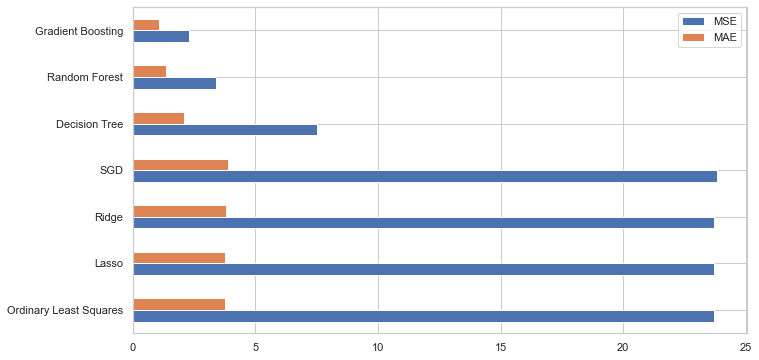

In [277]:
ax = metrics.plot(kind='barh', figsize=(11, 6))